## Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

### Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import math

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

data = pd.read_csv('/content/sample_data/cleaned_ecommerce_dataset.csv')
data.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category,item_id,item_price,user_city
0,4081,71900,Not always McCrap,McDonald's,4.0,3.0,M,Restaurants & Gourmet,41,30.74,4
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,1.0,4.0,M,Restaurants & Gourmet,74,108.30,4
2,4081,72000,The Wonderful World of Wendy,Wendy's,5.0,4.0,M,Restaurants & Gourmet,84,69.00,4
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",5.0,3.0,M,Movies,68,143.11,4
4,4081,100399,Hey! Gimme some pie!,American Pie,3.0,3.0,M,Movies,6,117.89,4


### Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict ratings given other columns, please get the correlations between helpfulness/gender/category/review and rating by using the `corr()` method.
* To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, category and review) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ corrleated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   rating       2685 non-null   float64
 5   helpfulness  2685 non-null   float64
 6   gender       2685 non-null   object 
 7   category     2685 non-null   object 
 8   item_id      2685 non-null   int64  
 9   item_price   2685 non-null   float64
 10  user_city    2685 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 230.9+ KB


In [4]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

print("Correlation between helpfulness and rating:", data.rating.corr(data.helpfulness))

# correlation between gender and rating
data["genderCode"] = ord_enc.fit_transform(data[["gender"]])
corGen = data.rating.corr(data.genderCode)
print("Correlation between gender and rating:", corGen)

# correlation between category and rating
data["CateCode"] = ord_enc.fit_transform(data[["category"]])
corCat = data.rating.corr(data.CateCode)
print("Correlation between category and rating:", corCat)

# correlation between review rating
data["ReCode"] = ord_enc.fit_transform(data[["review"]])
corRe = data.rating.corr(data.ReCode)
print("Correlation between review and rating:", corRe)

Correlation between helpfulness and rating: -0.00752333772684455
Correlation between gender and rating: -0.03433661424208268
Correlation between category and rating: -0.16315765340915642
Correlation between review and rating: -0.03611838655212237


**The highest correlation** is between category and rating comes to 0.163, as this indicate category does have impact on the level of rating.  

On the other hand, relationship between helpfulness and rating has **the lowest correlation** with 0.008, this show that helpfulness doesn't have (much)  impact on rating, but if there is they have a negative impact on rating, if the helpfulness point high, the rating wil be low.

Overall, none of them have a huge impact on rating, this indicates this data is randomized.



```
# This is formatted as code
```

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [5]:
# Case 1: training data containing 10% of the entire data
train, test = train_test_split(data, test_size=0.9, random_state=2)
print("Train set for case 1:", train.shape)
print("Test set for case 1:", test.shape, '\n')

# Case 2: training data containing 90% of the entire data
train2, test2 = train_test_split(data, test_size=0.1, random_state=2)
print("Train set for case 2:", train2.shape)
print("Test set for case 2:", test2.shape)

Train set for case 1: (268, 14)
Test set for case 1: (2417, 14) 

Train set for case 2: (2416, 14)
Test set for case 2: (269, 14)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features regarding rating, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

In [6]:
# liner regression model-a ( category and rating) in train test
reg = linear_model.LinearRegression()
X = train[['CateCode', 'ReCode']]
y = train['rating']
reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

# liner regression model-b ( helpfulness and rating) in train test
reg2 = linear_model.LinearRegression()
X2 = train[['genderCode','helpfulness']]
y2 = train['rating']
reg2.fit(X2, y2)
print("y = x *", reg2.coef_, "+", reg2.intercept_)


# liner regression model-c ( category and rating) in train2 test
reg3 = linear_model.LinearRegression()
X3 = train2[['CateCode', 'ReCode']]
y3 = train2['rating']
reg3.fit(X3, y3)
print("y = x *", reg3.coef_, "+", reg3.intercept_)


# liner regression model-d ( category and rating) in train test
reg4 = linear_model.LinearRegression()
X4 = train2[['genderCode','helpfulness']]
y4 = train2['rating']
reg4.fit(X4, y4)
print("y = x *", reg4.coef_, "+", reg4.intercept_)

y = x * [-0.05773838 -0.00029369] + 4.324936993886013
y = x * [ 0.23756985 -0.28030128] + 4.623460689753356
y = x * [-1.30690701e-01 -5.55393782e-05] + 4.430322878321464
y = x * [-0.07331768 -0.06191607] + 3.9814968996531372


**Comment**

It is evident from the above numbers that data size has an effect on the performance of a model. The larger training set (90%) makes the regression more reliable. When the test sample size is small, the level of bias will increase. When selecting the most correlative characteristics, the results will be more accurate and reliable.


### Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [7]:
# module-a
X_test = test[['CateCode', 'ReCode']]
y_test = test['rating']
predicted = reg.predict(X_test)
mse = ((np.array(y_test)-predicted)**2).sum()/len(y_test)
sqr_a = math.sqrt(mse)
print("MSE for module-a:", mse)
print("Square root of MSE:", sqr_a, '\n')

# module-b
X2_test = test[['genderCode', 'helpfulness']]
y2_test = test['rating']
predicted2 = reg2.predict(X2_test)
mse2 = ((np.array(y2_test)-predicted2)**2).sum()/len(y2_test)
sqr_b = math.sqrt(mse2)
print("MSE for module-b:", mse2)
print("Square root of MSE:", sqr_b, '\n')

# module-c
X3_test = test[['CateCode', 'ReCode']]
y3_test = test['rating']
predicted3 = reg3.predict(X3_test)
mse3= ((np.array(y3_test)-predicted3)**2).sum()/len(y3_test)
sqr_c = math.sqrt(mse3)
print("MSE for module-c:", mse3)
print("Square root of MSE:", sqr_c, '\n')

# module-d
X4_test = test[['genderCode', 'helpfulness']]
y4_test = test['rating']
predicted4 = reg4.predict(X4_test)
mse4 = ((np.array(y4_test)-predicted4)**2).sum()/len(y4_test)
sqr_d = math.sqrt(mse4)
print("MSE for module-d:", mse4)
print("Square root of MSE:", sqr_d)

MSE for module-a: 1.8076034748434535
Square root of MSE: 1.3444714481324822 

MSE for module-b: 1.8391262735328597
Square root of MSE: 1.3561438985346872 

MSE for module-c: 1.747146030339331
Square root of MSE: 1.321796516238158 

MSE for module-d: 1.7988337678689175
Square root of MSE: 1.341206087023511


### Visualize, Compare and Analyze the Results
* Visulize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

(1.6, 1.9)

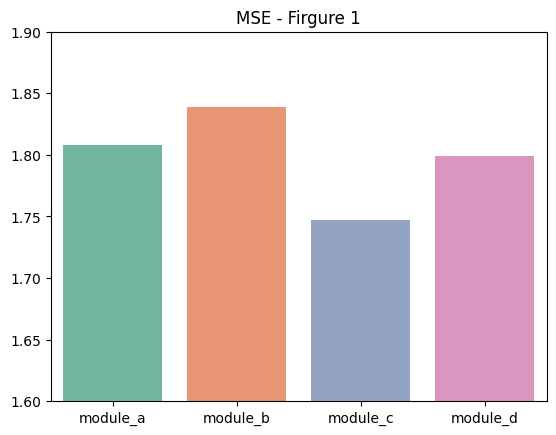

In [8]:
mseBar = sns.barplot(x= ['module_a', 'module_b', 'module_c', 'module_d'], y= [mse, mse2, mse3, mse4], palette= 'Set2')
mseBar.set(title ='MSE - Firgure 1')
mseBar.set_ylim(1.6,1.9)

(1.24, 1.38)

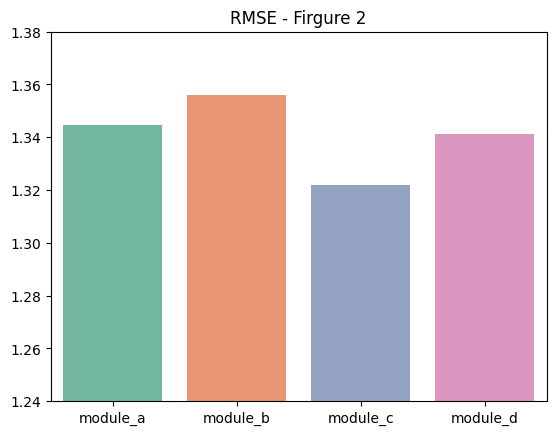

In [9]:
rmseBar = sns.barplot(x= ['module_a', 'module_b', 'module_c', 'module_d'], y= [sqr_a, sqr_b, sqr_c, sqr_d], palette= 'Set2')
rmseBar.set(title ='RMSE - Firgure 2')
rmseBar.set_ylim(1.24,1.38)

**Insightful analysis of the obtained results:**  
From both Figures 1 and 2, we can clearly see that Module 3 has the lowest for both mean squared error (mse) and root mean squared error (rmse). As stated in the question, with the most correlated features and the largest train data size will give a better results, module 3 is also met. With the largest data size (90%) and the two most correlated features, MSE and RMSE in the module are the lowest (1.75 and 1.32, respectively).

On the other hand, module-b has the least correlation features and the smaller train test size; therefore, module-b has the highest MSE and RMSE (1.84 and 1.36, respectively), which means this module has the highest chance of the predictions having large errors. The fact that modules a and d have approximately the same mse and rmse (approximately 1.80 and 1.34). This indicates that Module-a and Module-d, even though they have different feature selection and training sizes, tend to have similar prediction errors on average.

**The better result in the module training with the most correlated features and more training data**  
The module with the smallest mse and rmse will result in a better result because mse and rmse both tell us about the errors between the predicted values and the observed ones.

A lower MSE means that the predicted values are closer to the real values in terms of squared errors. It shows how well the model fits the data on average. Since RMSE considers the square root of the mean squared errors, it emphasises greater mistakes more than MSE does. Better performance may be indicated by a lower RMSE value if you wish to penalise huge mistakes more severely.

When doing a test, we want the error between the predicted data and the true one to be as small as possible; the smaller it is, the more accurate our test statistic. Therefore, the smaller the MSE and RMSE will decrease the errors, and in these data set, module-c will be the most suitable.